In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 11 10:48:58 2023

@author: bas, much copied from postprocessing tutorial
"""

# Importing relevant modules

# %matplotlib inline

# from __future__ import division

import sys
import os
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(42)

from xpsi.global_imports import gravradius


sys.path.append("../")
sys.path.append("../../")

from analysis import analysis
ST_marginalise = analysis('local','test', 'marginalise')
# We will use the same bounds used during sampling

# Settings names, bounds and labels

ST_marginalise.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature', 'column_density']

ST_marginalise.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(3.4, 3.6),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (5., 7.), #(6.5, 7.),
             'column_density': (0., 3.)}


# Now the labels
ST_marginalise.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'column_density': r"n_H 10\^21 cm\^{-2}"}

ST_marginalise.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 12.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*60/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.0,                    # Phase shift
          'p__super_colatitude': 45*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 15.5*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.0012,                      # Blackbody temperature
          'p__super_te': 100.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': 6.67,
          'column_density': 1.17}

ST_marginalise.truths['compactness']=gravradius(ST_marginalise.truths['mass'])/ST_marginalise.truths['radius']

#### SOMETHING SOMETHING COMPACTNESS

ST_marginalise.names +=['compactness']
ST_marginalise.bounds['compactness']=(0.0, 10.)#(gravradius(1.0)/16.0, 1.0/3.0)
ST_marginalise.labels['compactness']= r"M/R_{\mathrm{eq}}"



/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
Rank reporting: 0
cannot import analysis name, using default_analysis_name
num_energies from environment variables failed, proceeding with default.
num_leaves from environment variables failed, proceeding with default.
sqrt_num_cells from environment variables failed, proceeding with default.
live_points from environment variables failed, proceeding with default.
max_iter from environment variables failed, proceeding with default.
bkg environment variable is not allowed to be None, using passed argument: marginalise.
no background support in environment variables, proceeding with passed or de

In [2]:
ST_model = analysis('local', 'test', 'model')

ST_model.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature', 'T_in', 'R_in', 'column_density']

ST_model.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(3.4, 3.6),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (5., 7.), #(6.5, 7.),
             'T_in' : (0.01, 0.6), # keV
             'R_in' : (20, 64), # km
             'column_density': (0., 3.)}


# Now the labels
ST_model.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'T_in' : r"T_{in} log10 of Kelvin",
              'R_in': r"R_{in} km",
              'column_density': r"n_H 10\^21 cm\^{-2}"}

ST_model.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 12.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*60/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.0,                    # Phase shift
          'p__super_colatitude': 45*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 15.5*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.0012,                      # Blackbody temperature
          'p__super_te': 100.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': 6.67,
          'T_in': 6.4625672669218,
          'R_in': 30.,
          'column_density': 1.17}

ST_model.truths['compactness']=gravradius(ST_model.truths['mass'])/ST_model.truths['radius']

#### SOMETHING SOMETHING COMPACTNESS

ST_model.names +=['compactness']
ST_model.bounds['compactness']=(0.0, 10.)#(gravradius(1.0)/16.0, 1.0/3.0)
ST_model.labels['compactness']= r"M/R_{\mathrm{eq}}"


cannot import analysis name, using default_analysis_name
num_energies from environment variables failed, proceeding with default.
num_leaves from environment variables failed, proceeding with default.
sqrt_num_cells from environment variables failed, proceeding with default.
live_points from environment variables failed, proceeding with default.
max_iter from environment variables failed, proceeding with default.
bkg environment variable is not allowed to be None, using passed argument: model.
Creating parameter:
    > Named "column_density" with bounds [0.000e+00, 3.000e+00].
    > Units of 10^21 cm^-2.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds 

In [3]:
getdist_kde_settings = {'ignore_rows': 0,
                        'min_weight_ratio': 1.0e-10,
                        'contours': [0.683, 0.954, 0.997],
                        'credible_interval_threshold': 0.001,
                        'range_ND_contour': 0,
                        'range_confidence': 0.001,
                        'fine_bins': 1024,
                        'smooth_scale_1D': 0.4,
                        'num_bins': 100,
                        'boundary_correction_order': 1,
                        'mult_bias_correction_order': 1,
                        'smooth_scale_2D': 0.4,
                        'max_corr_2D': 0.99,
                        'fine_bins_2D': 512,
                        'num_bins_2D': 40}

In [4]:
base_dir='/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic/snellius_runs'

In [5]:
roots = []
job_ids = []
job_labels = []
run_ids = []

# negative background allowed, no support
# job_ids.append('5204648')
# job_labels.append('neg_bkg_lp192')

# fixed background
# job_ids.append('5133792')
# job_labels.append('given_bg_lp192')

# no support
# job_ids.append('4960988')
# job_labels.append('no_poisson_lp192')

# sf = 1.5, seed = 7
# job_ids.append('5210494')
# job_labels.append('sf_15_lp192')

# sf = 1.1, seed = 7
# job_ids.append('4977822')
# job_labels.append('np_sfac_1.1_lp192')
# job_ids.append('5216186')
# job_labels.append('sf_11_se_7_lp192')

# sf = 1.1, seed = 0
# job_ids.append('5210560')
# job_labels.append('sf_11_se_0_lp192')

# sf = 1.1, seed = 1
# job_ids.append('5210597')
# job_labels.append('sf_11_se_1_lp192')

# sf = 1.1, seed = 7, lp = 1000
# job_ids.append('5210748')
# job_labels.append('sf_11_lp1000')

# sf = 1.1, seed = 7, poisson noise
job_ids.append('5215731')
job_labels.append('sf_11_pn_lp192')
run_ids.append('sf_11')

# sf = 1.001
# job_ids.append('5134108')
# job_labels.append('sf_1001_lp192')
# run_ids.append('old')

# sf = 1.001 (2) 
# job_ids.append('5217380')
# job_labels.append('sf_1001_lp192')
# run_ids.append('new')

# sf = 1.001 negative background allowed, 
# job_ids.append('5206416')
# job_labels.append('nb_sf_1001_lp192')

# sf = 1.00005
# job_ids.append('5196881')
# job_labels.append('sf_100005_lp192')

# bkg_derived_lp192  
# job_ids.append('5316365')
# job_labels.append('bkg_derived_lp192')
# run_ids.append('bkg_derived')

# bkg_tight_lp192
# job_ids.append('5325163')
# job_labels.append('bkg_tight_lp192')
# run_ids.append('bkg_tight')


base_dirs = []
for job_id, job_label, index in zip(job_ids, job_labels, range(len(job_ids))):
    base_dirs.append(f'{base_dir}/{job_label}/{job_id}/{job_label}')
    roots.append('run_ST_')

In [6]:
marginalise_run_ids = run_ids[:]

ST_marginalise.runs = xpsi.Runs.load_runs(ID='ST_marginalise',
                               run_IDs=marginalise_run_ids,
                               roots=roots,
                               base_dirs=base_dirs,
                               use_nestcheck=[False]*len(job_ids),
                               kde_settings=getdist_kde_settings,
                               likelihood=ST_marginalise.likelihood,
                               names=ST_marginalise.names,
                               bounds=ST_marginalise.bounds,
                               labels=ST_marginalise.labels,
                               truths=ST_marginalise.truths,
                               implementation='multinest',
                               overwrite_transformed=True)

In [7]:
roots = []
job_ids = []
job_labels = []
run_ids = []


# bkg_tight_lp192
job_ids.append('5325163')
job_labels.append('bkg_tight_lp192')
run_ids.append('bkg_tight')


base_dirs = []
for job_id, job_label, index in zip(job_ids, job_labels, range(len(job_ids))):
    base_dirs.append(f'{base_dir}/{job_label}/{job_id}/{job_label}')
    roots.append('run_ST_')

In [8]:
model_run_ids = run_ids[:]

ST_model.runs = xpsi.Runs.load_runs(ID='ST_model',
                               run_IDs=model_run_ids,
                               roots=roots,
                               base_dirs=base_dirs,
                               use_nestcheck=[False]*len(job_ids),
                               kde_settings=getdist_kde_settings,
                               likelihood=ST_marginalise.likelihood,
                               names=ST_marginalise.names,
                               bounds=ST_marginalise.bounds,
                               labels=ST_marginalise.labels,
                               truths=ST_marginalise.truths,
                               implementation='multinest',
                               overwrite_transformed=True)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['mass', 'radius']
plotting:  ['mass', 'compactness']
plotting:  ['radius', 'compactness']
Veneering spines and axis ticks...
Veneered.
Adding parameter truth crosshairs...
Added crosshairs.
Adding 1D marginal credible intervals...
Plotting credible regions for posterior ST_marginalise...
Added 1D marginal credible intervals.
Constructed lower-triangle posterior density plot.
Posterior density estimation complete.


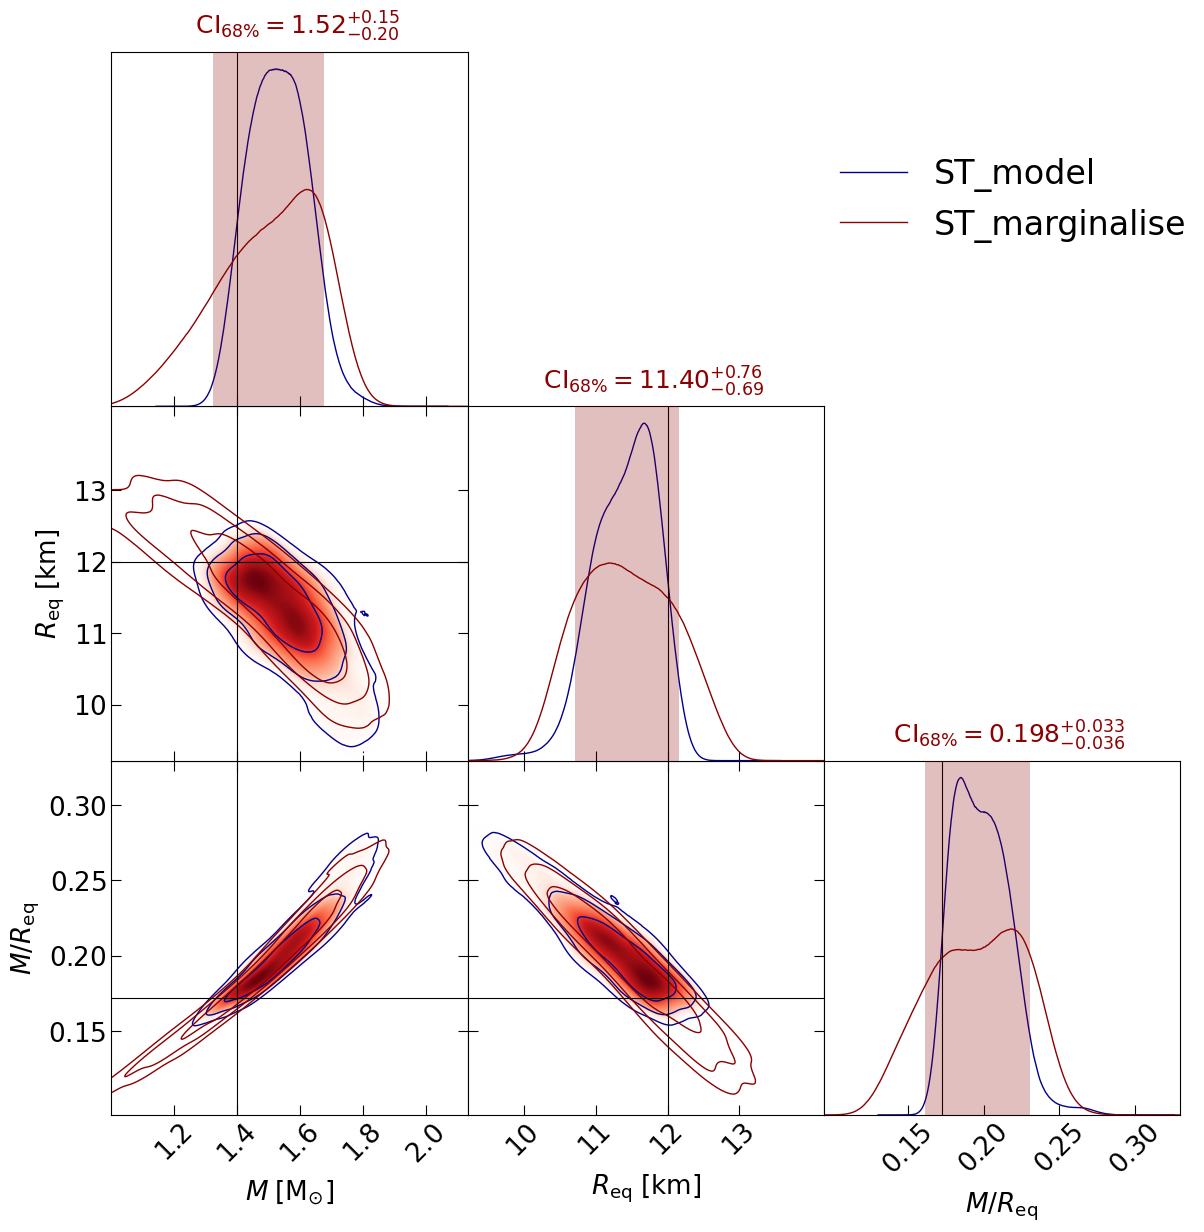

In [9]:
only_three = ["mass", "radius", "compactness"]

pp = xpsi.PostProcessing.CornerPlotter([ST_marginalise.runs, ST_model.runs])
fig = pp.plot(
     params=only_three,
     IDs=OrderedDict([('ST_marginalise', marginalise_run_ids),('ST_model', model_run_ids)]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)



In [10]:
pp = xpsi.SignalPlotter([ST.runs])
pp.plot(IDs=OrderedDict([('ST', run_ids),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        force_cache=True,
        nsamples=3,
        plots = {'ST': xpsi.ResidualPlot()})

pp.plots["ST"].fig


#%%

# plt.savefig(f'./corner_run_se={sampling_efficiency}_lp={live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iterations}.png')



NameError: name 'ST' is not defined

pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=["mass", "radius", "compactness"],
     IDs=OrderedDict([('ST', job_labels),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)



In [ ]:
pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=ST.names,
     IDs=OrderedDict([('ST', run_ids),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)